In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KDTree;
import os;
import re;
import logging;
import sqlite3;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt;
from itertools import cycle;
%matplotlib inline

In [3]:
pf_df = pd.read_csv('kaggle_poem_dataset.csv')
pf_df['Author'] = pf_df.Author.astype('category')

<AxesSubplot:xlabel='Author'>

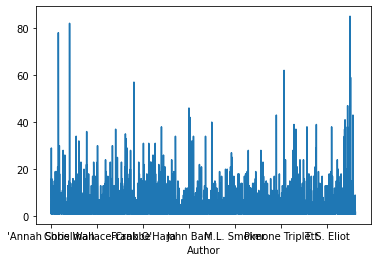

In [5]:
X = pf_df.copy()
fig, ax = plt.subplots()
X.groupby('Author').count()['Title'].plot(ax=ax)

        Unnamed: 0        Title  Poetry Foundation ID      Content
count  3310.000000  3310.000000           3310.000000  3310.000000
mean      4.728701     4.728701              4.728701     4.728701
std       6.428874     6.428874              6.428874     6.428874
min       1.000000     1.000000              1.000000     1.000000
25%       1.000000     1.000000              1.000000     1.000000
50%       2.000000     2.000000              2.000000     2.000000
75%       6.000000     6.000000              6.000000     6.000000
max      85.000000    85.000000             85.000000    85.000000


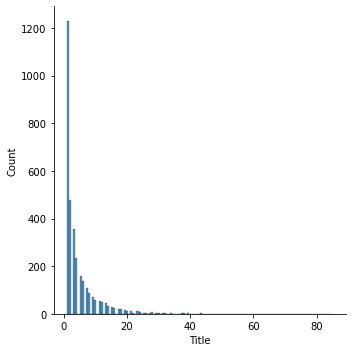

In [21]:
count_df = X.groupby('Author').count()
print(count_df.describe())
sns.displot(data = count_df, x='Title')

In [ ]:
count_df.sort_values(inplace=True)


In [4]:
# clean and stack ngram
stacked_ngrams = X.stack()
print(stacked_ngrams.head())
ngrams = stacked_ngrams.values
print(len(list(ngrams)))

0  Date                                            2008-08-08
   Label                                                    0
   Top1     b"Georgia 'downs two Russian warplanes' as cou...
   Top2               b'BREAKING: Musharraf to be impeached.'
   Top3     b'Russia Today: Columns of troops roll into So...
dtype: object
53696


In [5]:
# X_pivot = X.pivot(index='Date', columns=X.columns)
# X_pivot.melt(id_vars=['Label'], value_vars=X_pivo)
X_melt = pd.melt(X,id_vars=['Date','Label'], value_name='Ngram')
X_melt.head()

,Date,Label,variable,Ngram
0,2008-08-08,0,Top1,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-11,1,Top1,b'Why wont America and Nato help us? If they w...
2,2008-08-12,0,Top1,b'Remember that adorable 9-year-old who sang a...
3,2008-08-13,0,Top1,b' U.S. refuses Israel weapons to attack Iran:...
4,2008-08-14,1,Top1,b'All the experts admit that we should legalis...


In [6]:
from sklearn import preprocessing as skpp
le = skpp.LabelEncoder().fit(X_melt['variable'])
top_encoded = le.transform(X_melt['variable'])
X_melt['top_n']= top_encoded
X_melt = X_melt.drop('variable', axis=1)
X_melt.head()
X_melt.columns = [i.lower() for i in X_melt.columns]
X_melt.head()

,date,label,ngram,top_n
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",0
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,0
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,0
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,0
4,2008-08-14,1,b'All the experts admit that we should legalis...,0


In [7]:
import re
import html
import string
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from nltk.corpus import stopwords

def preprocess_text(text):
    cont_dict = { 
        "ain't": "am not / are not / is not / has not / have not",
        "aren't": "are not / am not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he had / he would",
        "he'd've": "he would have",
        "he'll": "he shall / he will",
        "he'll've": "he shall have / he will have",
        "he's": "he has / he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how has / how is / how does",
        "I'd": "I had / I would",
        "I'd've": "I would have",
        "I'll": "I shall / I will",
        "I'll've": "I shall have / I will have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it had / it would",
        "it'd've": "it would have",
        "it'll": "it shall / it will",
        "it'll've": "it shall have / it will have",
        "it's": "it has / it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she had / she would",
        "she'd've": "she would have",
        "she'll": "she shall / she will",
        "she'll've": "she shall have / she will have",
        "she's": "she has / she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as / so is",
        "that'd": "that would / that had",
        "that'd've": "that would have",
        "that's": "that has / that is",
        "there'd": "there had / there would",
        "there'd've": "there would have",
        "there's": "there has / there is",
        "they'd": "they had / they would",
        "they'd've": "they would have",
        "they'll": "they shall / they will",
        "they'll've": "they shall have / they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we had / we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what shall / what will",
        "what'll've": "what shall have / what will have",
        "what're": "what are",
        "what's": "what has / what is",
        "what've": "what have",
        "when's": "when has / when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where has / where is",
        "where've": "where have",
        "who'll": "who shall / who will",
        "who'll've": "who shall have / who will have",
        "who's": "who has / who is",
        "who've": "who have",
        "why's": "why has / why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you had / you would",
        "you'd've": "you would have",
        "you'll": "you shall / you will",
        "you'll've": "you shall have / you will have",
        "you're": "you are",
        "you've": "you have"
        }

    stopwords_list = stopwords.words("english")
    try:
        while text.startswith('b'):
            text = text[1:]
        text = text.lower()
        for word in cont_dict.keys():
            pattern = re.compile(f'({str(word)})',re.I)
            text = pattern.sub(cont_dict[word],text)
    #     print(text[:50])
        tokens = word_tokenize(text)
        text = ' '.join([word for word in tokens if word not in stopwords_list])
    #     print(text[:50])
        text = ' '.join([''.join([c if c.isalnum() else ' ' for c in word]) for word in word_tokenize(text)])
        text = re.sub(' +', ' ', text)
        
    #     print(text[:50])
        return text.strip()
    
    except AttributeError:
        text = str(text)
        return preprocess_text(text)
    
    except TypeError:
        text = text.decode()[1:]
        return preprocess(text.strip())

def preprocess_ngram_column(df):
    return df.ngram.map(lambda x: preprocess_text(x))

text = "I don't like bats, but I do like 39/2 hats!"
clean_text = preprocess_text(text)
print(clean_text)

like bats like 39 2 hats


In [8]:
print(X_melt.head())
X_melt['ngram'] = preprocess_ngram_column(X_melt)
print(X_melt.head())

         date  label                                              ngram  top_n
0  2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...      0
1  2008-08-11      1  b'Why wont America and Nato help us? If they w...      0
2  2008-08-12      0  b'Remember that adorable 9-year-old who sang a...      0
3  2008-08-13      0  b' U.S. refuses Israel weapons to attack Iran:...      0
4  2008-08-14      1  b'All the experts admit that we should legalis...      0
         date  label                                              ngram  top_n
0  2008-08-08      0  georgia downs two russian warplanes countries ...      0
1  2008-08-11      1  why wont america nato help us wont help us hel...      0
2  2008-08-12      0  remember adorable 9 year old sang opening cere...      0
3  2008-08-13      0      u s refuses israel weapons attack iran report      0
4  2008-08-14      1                   all experts admit legalise drugs      0


In [9]:
corpus = X_melt.ngram.to_list()

In [10]:
from collections import Counter
print(corpus[0])

georgia downs two russian warplanes countries move brink war


In [11]:
from sklearn.model_selection import train_test_split
X_train_corpus, X_test_corpus, y_train_corpus, y_test_corpus = train_test_split(corpus, X_melt.label, random_state=13)

In [12]:
# score candidate models for transforming and classifying with headlines
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from gensim.sklearn_api import W2VTransformer, D2VTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

tfidf= TfidfVectorizer()
cv = CountVectorizer()
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())])
w2v = W2VTransformer()
d2v = D2VTransformer()
# transformers = [('tfidf', tfidf), ('cv', cv), 'w2v', W2VTransformer]
transformers = [('cv', cv), 
                ('tfidf', tfidf), 
                ('cv2tfidf', pipe)]

mNB = MultinomialNB()
lr = LogisticRegression(max_iter=10000)
rc = RidgeClassifier(max_iter=10000)
# gb=GradientBoostingClassifier(random_state=13,
#                               subsample=0.8, 
#                               max_features="auto")
sgdc = SGDClassifier()
# svc=svm.SVC(random_state=13, 
#             max_iter=10000, 
#             kernel='rbf')
rf=RandomForestClassifier(random_state=13, 
                          n_jobs=-1, 
                          max_features="auto")

classifiers = [mNB, lr, rc, sgdc, rf]

best_clf, best_score = None, 0

for t in transformers:
    try:
        X = Pipeline([t]).fit_transform(X_train_corpus)
        X_train, X_test, y_train, y_test = train_test_split(X, y_train_corpus, random_state=13)
        for clf in classifiers:
            try:
                clf.fit(X_train, y_train)
                score = clf.score(X_test, y_test)
                if score > best_score:
                    best_score, best_estimator, best_transformer = score, clf, str(t)
            except:
                print(f'Error classifying with {str(clf)}')
                continue
    except:
        print(f'Error fitting and transforming with {str(t[0])}')
        continue
    

In [13]:
print(best_estimator)
print(best_score)
print(best_transformer)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
0.5262762762762763
('cv2tfidf', Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
               

In [14]:
# tune hyperparameters for the best scoring candidate encoder
pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgdc', SGDClassifier()),
])

parameters = {
    'cv__max_df': (0.25, 0.5, 0.75, 1.0),
    'cv__ngram_range': ((1, 1), (1, 2), (1,3), (1,4), (2,4), (2,5), (3,6), (2,7)),
    'sgdc__alpha': (0.00001, 0.000001),
    'sgdc__penalty': ('l2', 'elasticnet'),
}


text_gs = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

text_gs.fit(X_train_corpus, y_train_corpus)

print("Best score: %0.3f" % text_gs.best_score_)
print("Best parameters set:")
best_parameters = text_gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.1min finished


Best score: 0.535
Best parameters set:
	cv__max_df: 0.75
	cv__ngram_range: (3, 6)
	sgdc__alpha: 1e-06
	sgdc__penalty: 'l2'


In [15]:
print(text_gs.best_estimator_.predict(corpus[0:10]))

[0 1 0 0 1 1 1 1 1 1]


In [58]:
final_X = X_melt.copy().drop('label',axis=1)
# print(final_X.head())
# final_X.set_index('date',inplace=True,drop=True)
final_X.ngram = text_gs.best_estimator_.predict(corpus)
final_X = final_X.pivot(index='date', columns='top_n')
# print(final_X.info())
y = text_stock_df.Label
# print(y.describe())
# print(final_X.info())
final_X.info()
weights = [1/i for i in range(1,26)]
votes = final_X.mean(axis=1)
votes_binary = [round(x) for x in votes]
print(len(votes_binary))
print(len(y))
print(type(y[0]), type(votes_binary[0]))
cr = classification_report(y, votes_binary)

<class 'pandas.core.frame.DataFrame'>
Index: 1989 entries, 2008-08-08 to 2016-07-01
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   (ngram, 0)   1989 non-null   int64
 1   (ngram, 1)   1989 non-null   int64
 2   (ngram, 2)   1989 non-null   int64
 3   (ngram, 3)   1989 non-null   int64
 4   (ngram, 4)   1989 non-null   int64
 5   (ngram, 5)   1989 non-null   int64
 6   (ngram, 6)   1989 non-null   int64
 7   (ngram, 7)   1989 non-null   int64
 8   (ngram, 8)   1989 non-null   int64
 9   (ngram, 9)   1989 non-null   int64
 10  (ngram, 10)  1989 non-null   int64
 11  (ngram, 11)  1989 non-null   int64
 12  (ngram, 12)  1989 non-null   int64
 13  (ngram, 13)  1989 non-null   int64
 14  (ngram, 14)  1989 non-null   int64
 15  (ngram, 15)  1989 non-null   int64
 16  (ngram, 16)  1989 non-null   int64
 17  (ngram, 17)  1989 non-null   int64
 18  (ngram, 18)  1989 non-null   int64
 19  (ngram, 19)  1989 non-null   int64
 20

In [59]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       924
           1       1.00      1.00      1.00      1065

    accuracy                           1.00      1989
   macro avg       1.00      1.00      1.00      1989
weighted avg       1.00      1.00      1.00      1989



In [40]:
# score candidates with headline votes for final classifier
classifiers = [mNB, lr, rc, sgdc, rf]

best_clf, best_score = None, 0

X_train, X_test, y_train, y_test = train_test_split(final_X, y, test_size=0.3, stratify=y, random_state=13)
for clf in classifiers:
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if score > best_score:
        best_score, best_estimator = score, clf

In [41]:
print(best_score)
print(best_estimator)

1.0
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [36]:
from sklearn.model_selection import RepeatedStratifiedKFold
lr = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga']
penalty = ['l2','elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
param_grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=13)
fin_gs = GridSearchCV(lr, param_grid, cv=cv, n_jobs=-1, scoring='accuracy', error_score=0, verbose=1)
grid_res = fin_gs.fit(X_train, y_train)

print("Best score: %0.3f" % fin_gs.best_score_)
print("Best parameters set:")
best_parameters = fin_gs.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 30 folds for each of 40 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    0.9s


Best score: 1.000
Best parameters set:
	C: 100
	penalty: 'l2'
	solver: 'newton-cg'


[Parallel(n_jobs=-1)]: Done 846 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    3.1s finished


Classification report on training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       693
           1       1.00      1.00      1.00       798

    accuracy                           1.00      1491
   macro avg       1.00      1.00      1.00      1491
weighted avg       1.00      1.00      1.00      1491

Classification report on test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       231
           1       1.00      1.00      1.00       267

    accuracy                           1.00       498
   macro avg       1.00      1.00      1.00       498
weighted avg       1.00      1.00      1.00       498

[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]


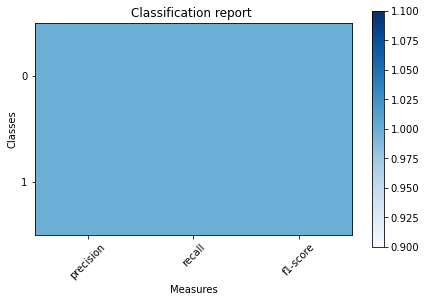

In [37]:
from sklearn.metrics import classification_report

def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        #print(line)
        t = line.split()
        # print(t)
        if len(t)==0:
            break
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

best_model = fin_gs.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
cr_train = classification_report(y_train, y_train_pred)
cr_test = classification_report(y_test, y_test_pred)
print("Classification report on training set")
print(cr_train)
print("Classification report on test set")
# plot_classification_report(cr_train)
print(cr_test)
plot_classification_report(cr_test)

In [39]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
base_preds = pd.Series([1]*len(y_test))

for preds in [base_preds, y_test_pred]:
    print('ROCAUC score:',roc_auc_score(y_test, preds))
    print('Accuracy score:',accuracy_score(y_test, preds))
    print('F1 score:',f1_score(y_test, preds))

ROCAUC score: 0.5
Accuracy score: 0.536144578313253
F1 score: 0.6980392156862745
ROCAUC score: 1.0
Accuracy score: 1.0
F1 score: 1.0
